In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import Input
from keras import backend as K
from keras.applications import vgg16

Using TensorFlow backend.


In [2]:
def preprocess(img):
    img4d=img.copy()
    img4d = img4d.astype("float64")
    if K.image_dim_ordering()=="th":
        #(H,W,C) -> (C,H,W)
        img4d=img4d.traanspose((2,0,1))
    img4d=np.expand_dims(img4d,axis=0)
    img4d=vgg16.preprocess_input(img4d)
    return img4d

In [3]:
def deprocess(img4d):
    img = img4d.copy()
    if K.image_dim_ordering() == "th":
        # (B, C, H, W)
        img = img.reshape((img4d.shape[1], img4d.shape[2], img4d.shape[3]))
        # (C, H, W) -> (H, W, C)
        img = img.transpose((1, 2, 0))
    else:
        # (B, H, W, C)
        img = img.reshape((img4d.shape[1], img4d.shape[2], img4d.shape[3]))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # BGR -> RGB
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [4]:
img=plt.imread("cat.jpg")
img_copy=img.copy()
print("Original shape ",img.shape)

Original shape  (124, 119, 3)


In [5]:
image_shape_width=img.shape[0]
image_shape_height=img.shape[1]
p_img=preprocess(img_copy)
print("After preprocessing ",p_img.shape)

After preprocessing  (1, 124, 119, 3)


In [6]:
d_img=deprocess(p_img)
print("After deprocessing ",d_img.shape)

After deprocessing  (124, 119, 3)


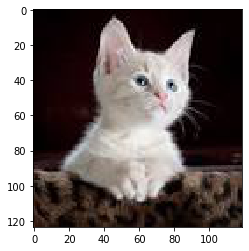

In [7]:
plt.imshow(d_img)
plt.show()

In [8]:
# pretrained vgg16
batch_shape=p_img.shape
dream=Input(batch_shape=batch_shape)
model=vgg16.VGG16(input_tensor=dream,weights="imagenet",include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
layer_dict={layer.name:layer for layer in model.layers}
layer_dict

{'input_1': <keras.engine.input_layer.InputLayer at 0x27f8947d4a8>,
 'block1_conv1': <keras.layers.convolutional.Conv2D at 0x27f8947d128>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x27f8947d400>,
 'block1_pool': <keras.layers.pooling.MaxPooling2D at 0x27f89485160>,
 'block2_conv1': <keras.layers.convolutional.Conv2D at 0x27f89485e80>,
 'block2_conv2': <keras.layers.convolutional.Conv2D at 0x27f894ef4e0>,
 'block2_pool': <keras.layers.pooling.MaxPooling2D at 0x27f8950abe0>,
 'block3_conv1': <keras.layers.convolutional.Conv2D at 0x27f8950a6a0>,
 'block3_conv2': <keras.layers.convolutional.Conv2D at 0x27f89543400>,
 'block3_conv3': <keras.layers.convolutional.Conv2D at 0x27f89532a58>,
 'block3_pool': <keras.layers.pooling.MaxPooling2D at 0x27f895926d8>,
 'block4_conv1': <keras.layers.convolutional.Conv2D at 0x27f89592588>,
 'block4_conv2': <keras.layers.convolutional.Conv2D at 0x27f89416cf8>,
 'block4_conv3': <keras.layers.convolutional.Conv2D at 0x27f89424e48>,
 'block4_poo

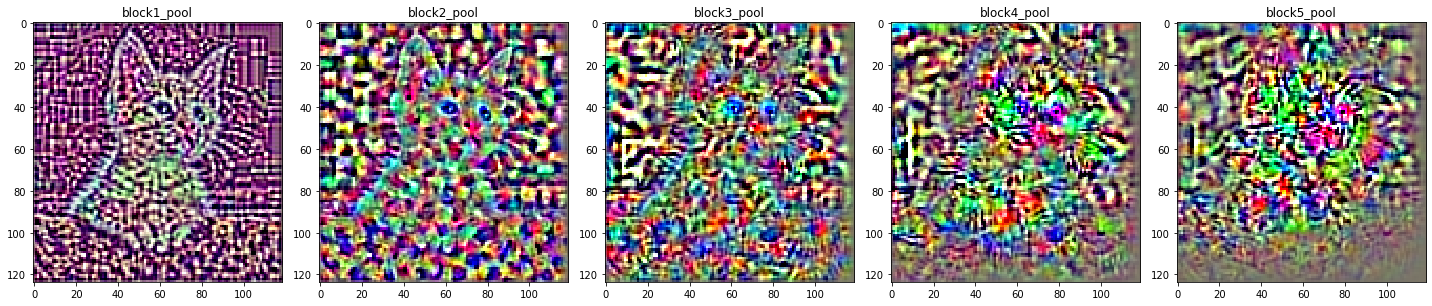

In [10]:
# visualise gradients at pooling layers
num_pool_layers=5;
lr=0.01
fig,axes=plt.subplots(1,num_pool_layers,figsize=(20,10))
for i in range(num_pool_layers):
    layer_name="block{:d}_pool".format(i+1)
    layer_output=layer_dict[layer_name].output
    loss=K.mean(layer_output)
    grads=K.gradients(loss,dream)[0]
    grads/=(K.sqrt(K.mean(K.square(grads)))+1e-5)*lr
    f=K.function([dream],[loss,grads])
    img_value=p_img.copy()
    loss_value,grads_value=f([img_value])
    axes[i].set_title(layer_name)
    axes[i].imshow(deprocess(grads_value))
plt.tight_layout()
plt.show()

In [11]:
# deep dreaming
first_layer=model.layers[-1]
input_img=first_layer.input
print(first_layer.name,first_layer.output_shape)

block5_pool (1, 3, 3, 512)


In [12]:
num_pool_layers=5
num_iters_per_layer=3
step=2000

Pooling layer: block1_pool


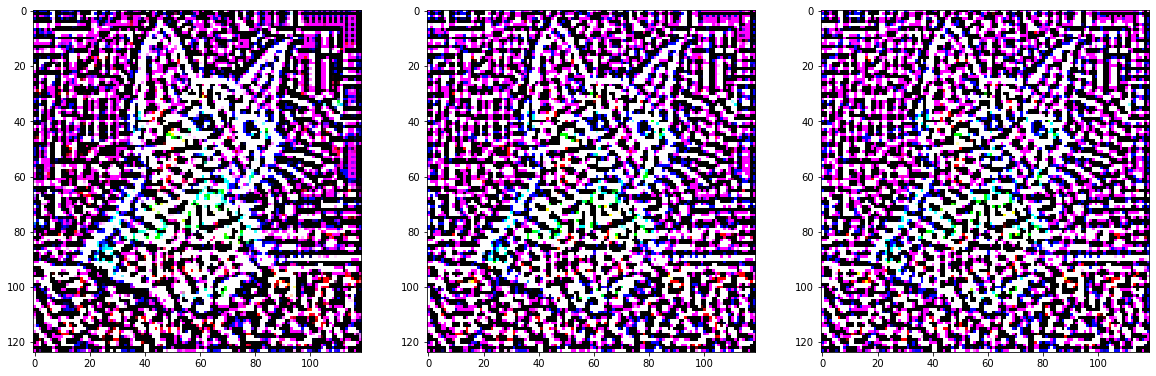

Pooling layer: block2_pool


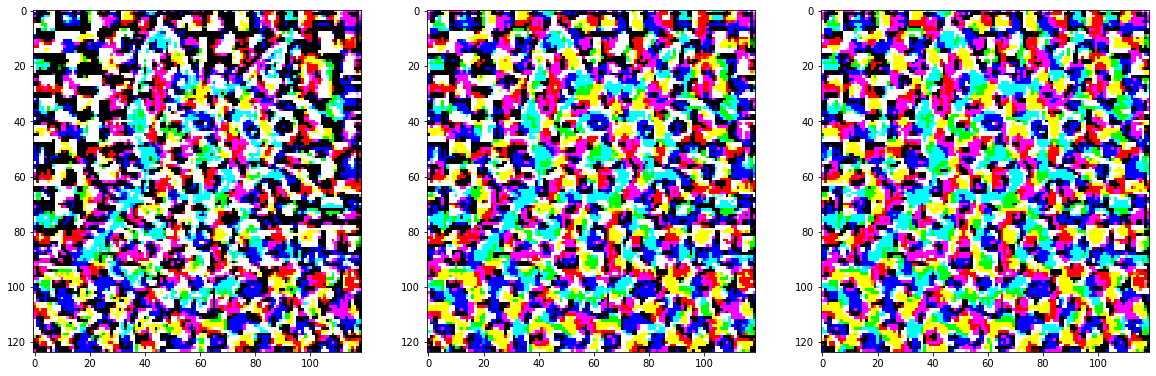

Pooling layer: block3_pool


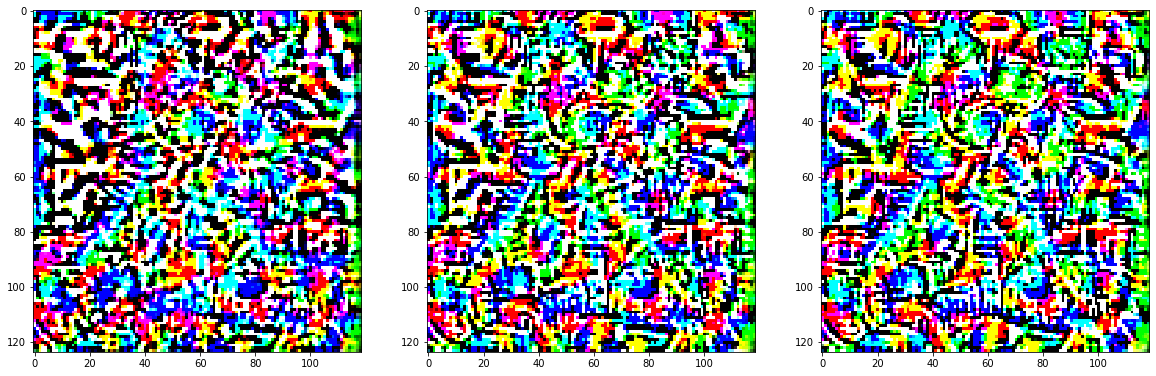

Pooling layer: block4_pool


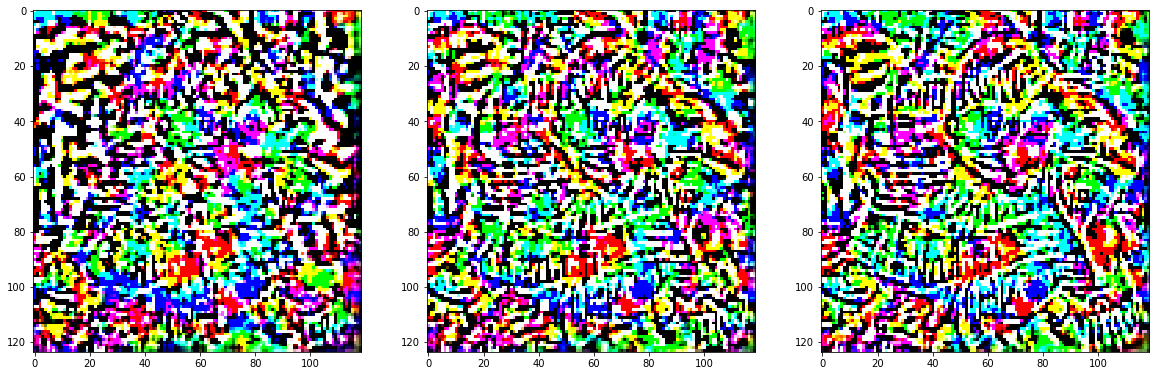

Pooling layer: block5_pool


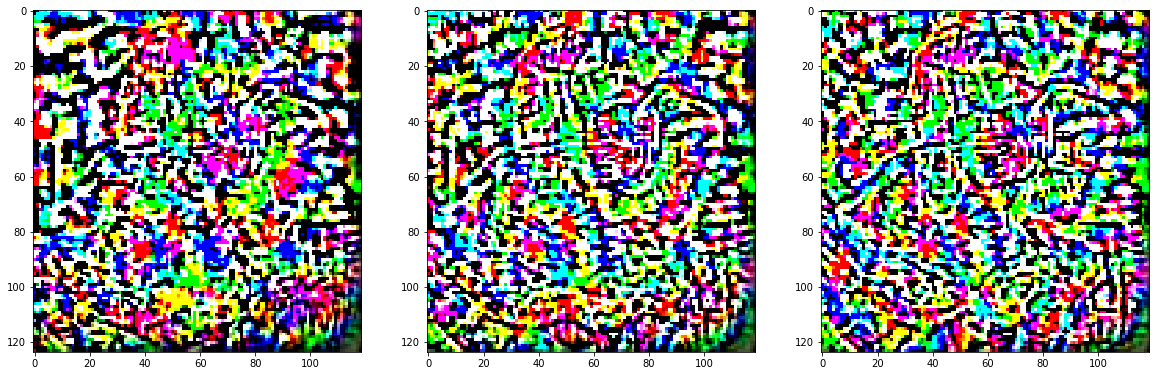

In [13]:
for i in range(num_pool_layers):
    layer_name="block{:d}_pool".format(i+1)
    print("Pooling layer: {:s}".format(layer_name))
    layer_output=layer_dict[layer_name].output
    #loss
    loss=K.mean(layer_output)
    #gradient
    grads=K.gradients(loss,dream)[0]
    grads/=(K.sqrt(K.mean(K.square(grads)))+1e-5)
    #optimizer
    f=K.function([dream],[loss,grads])
    img_value=p_img.copy()
    fig,axes=plt.subplots(1,num_iters_per_layer,figsize=(20,10))
    
    for it in range(num_iters_per_layer):
        loss_value,grads_value=f([img_value])
        img_value+=grads_value*step
        axes[it].imshow(deprocess(img_value))
    plt.show()

(124, 119, 3)


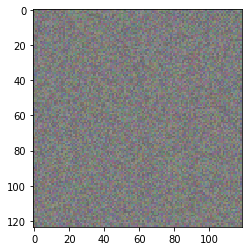

In [14]:
# try to dream structure out of random noise
img_noise=np.random.randint(100,150,size=(image_shape_width,image_shape_height,3),dtype=np.uint8)
print(img_noise.shape)
plt.imshow(img_noise)
plt.show()

In [15]:
p_img = img_noise.copy()
p_img = preprocess(p_img)
num_pool_layers = 5
num_iters_per_layer = 3
step = 2000

pooling layer block1_pool


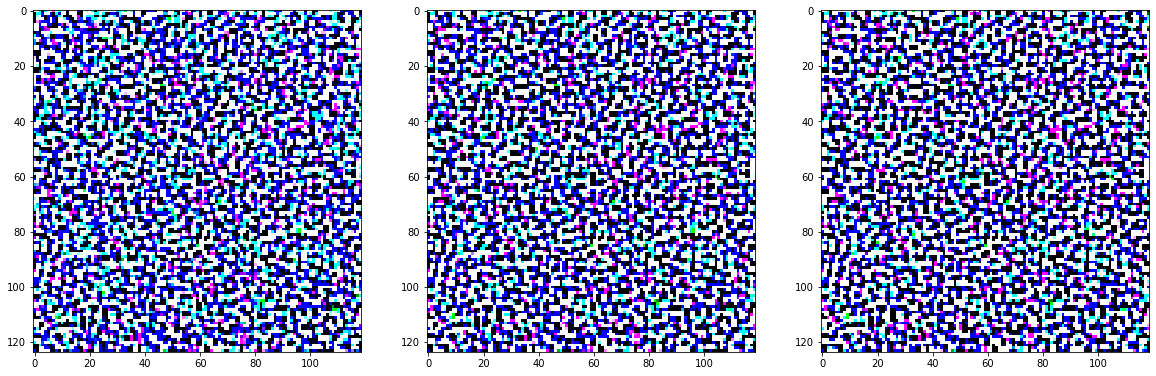

pooling layer block2_pool


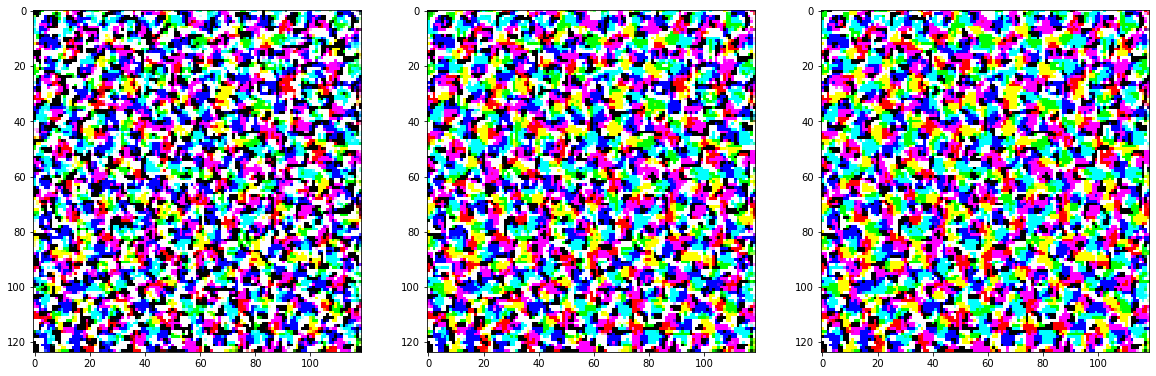

pooling layer block3_pool


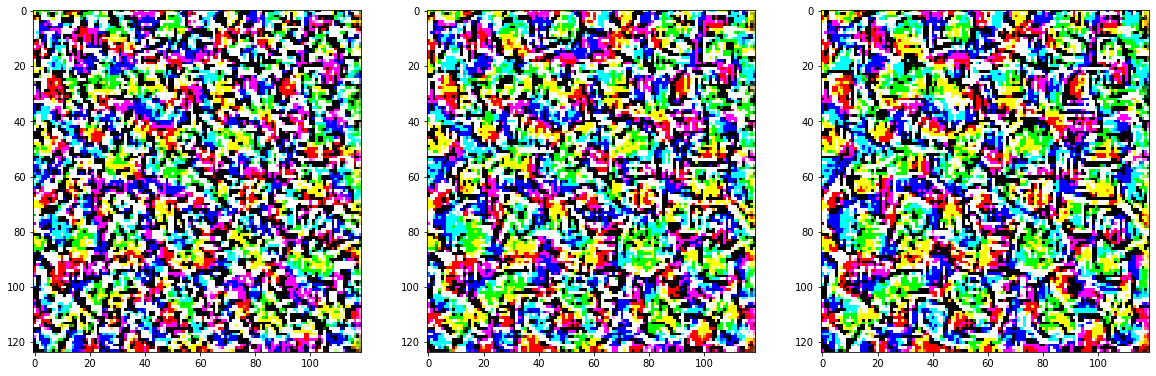

pooling layer block4_pool


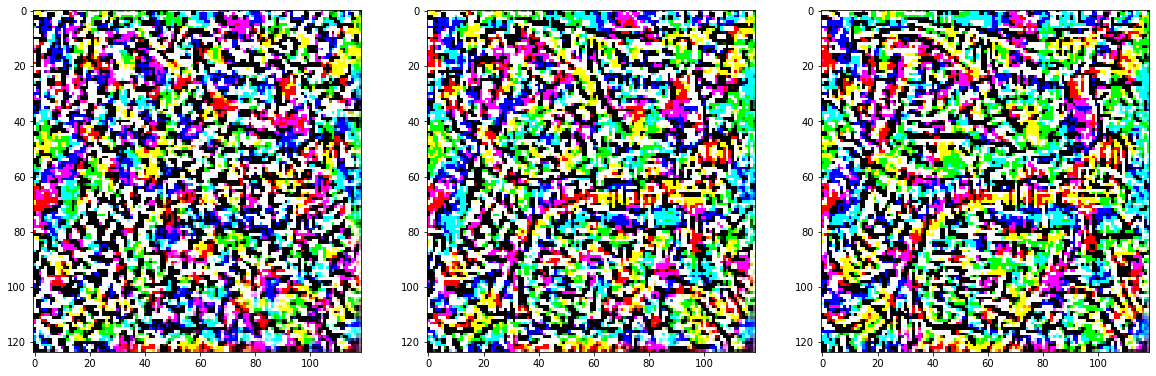

pooling layer block5_pool


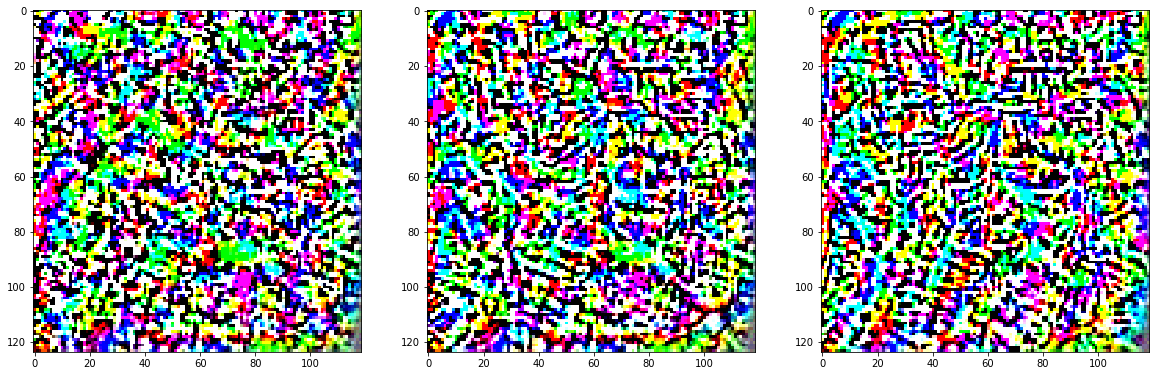

In [16]:
for i in range(num_pool_layers):
    layer_name="block{:d}_pool".format(i+1)
    print("pooling layer {:s}".format(layer_name))
    layer_output=layer_dict[layer_name].output
    
    #loss
    loss=K.mean(layer_output)
    
    #gradient
    grads=K.gradients(loss,dream)[0]
    grads/=(K.sqrt(K.mean(K.square(grads)))+1e-5)
    
    #optimizer
    f=K.function([dream],[loss,grads])
    img_value=p_img.copy()
    fig,axes=plt.subplots(1,num_iters_per_layer,figsize=(20,10))
    for it in range(num_iters_per_layer):
        loss_value,grads_value=f([img_value])
        img_value+=grads_value*step
        axes[it].imshow(deprocess(img_value))
    plt.show()

Pooling Layer: block1_pool


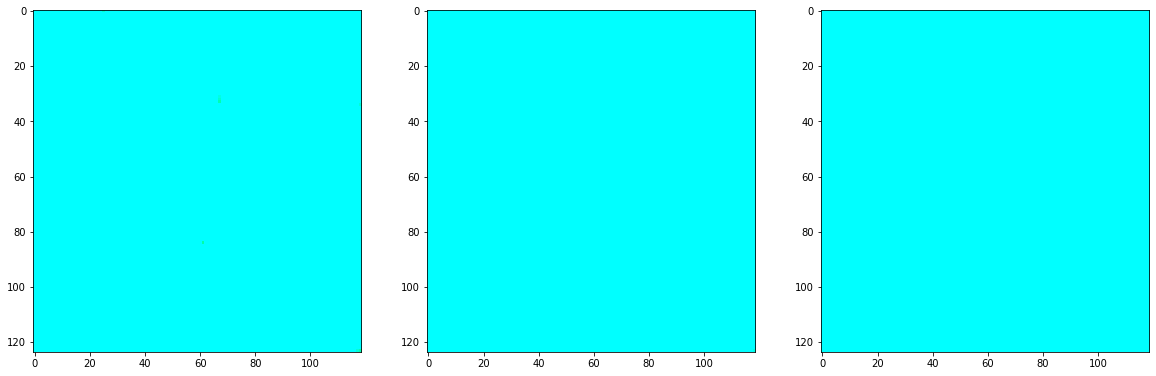

Pooling Layer: block2_pool


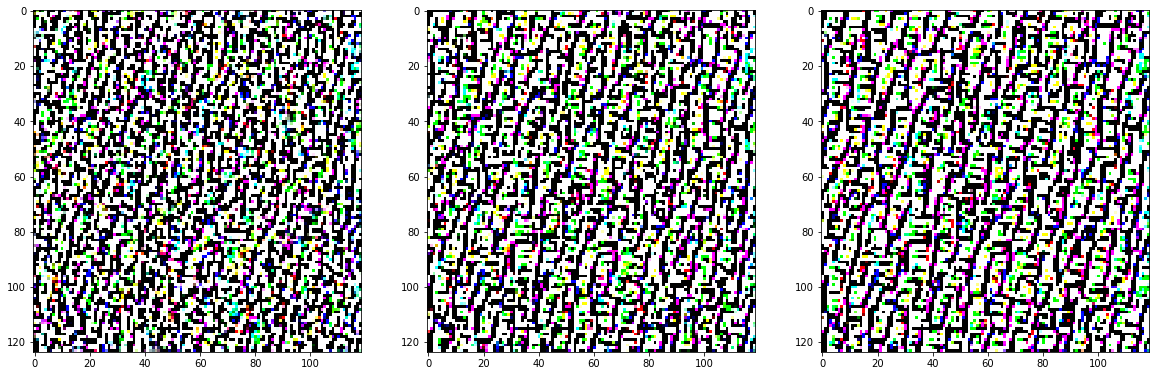

Pooling Layer: block3_pool


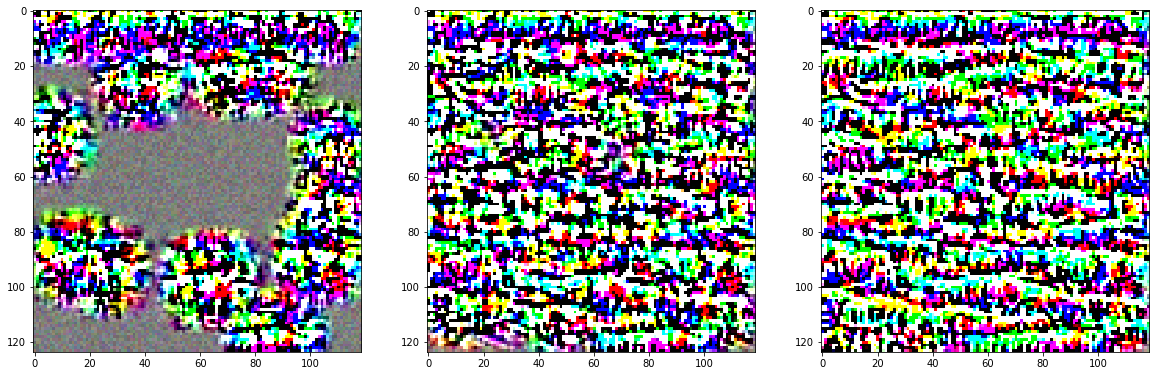

Pooling Layer: block4_pool


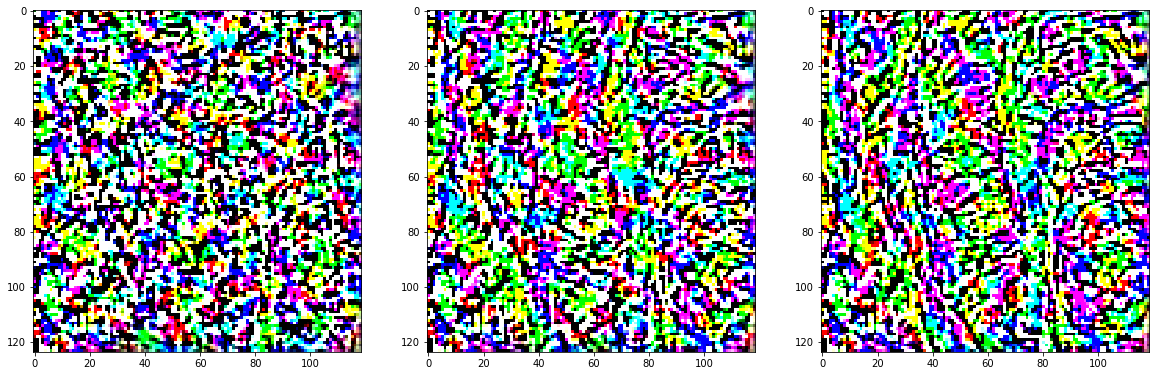

Pooling Layer: block5_pool


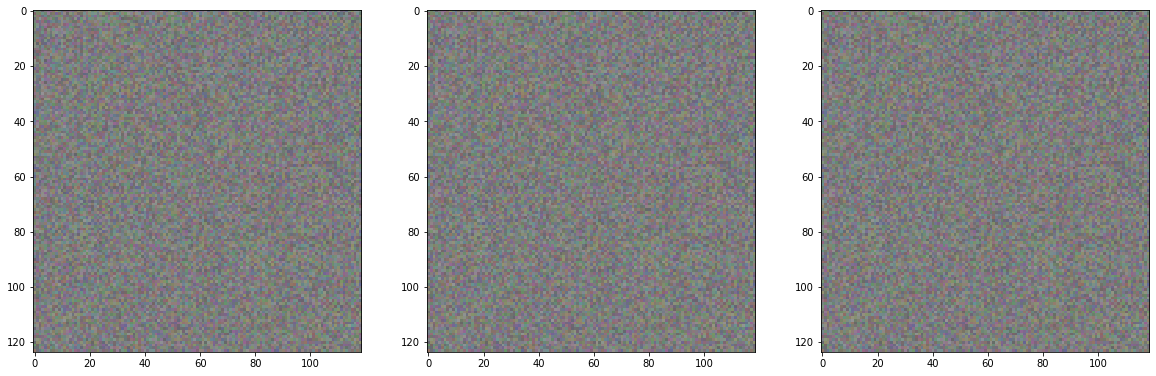

In [17]:
#Only do gradient ascent on specific label and see that this pattern shows up
for i in range(num_pool_layers):
    layer_name = "block{:d}_pool".format(i+1)
    print("Pooling Layer: {:s}".format(layer_name))
    layer_output = layer_dict[layer_name].output
    # loss function
    loss = layer_output[:, :, :, 24]
    # gradient
    grads = K.gradients(loss, dream)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    # optimizer
    f = K.function([dream], [loss, grads])
    img_value = p_img.copy()
    fig, axes = plt.subplots(1, num_iters_per_layer, figsize=(20, 10))
    for it in range(num_iters_per_layer):
        loss_value, grads_value = f([img_value])
        img_value += grads_value * step
        axes[it].imshow(deprocess(img_value))
    plt.show()

In [18]:
img=plt.imread("dog.jpg")
img_copy=img.copy()
print("Original shape ",img.shape)
image_shape_width=img.shape[0]
image_shape_height=img.shape[1]
p_img=preprocess(img_copy)
print("After processing ",p_img.shape)
d_img=deprocess(p_img)
print("After deprocessing ",d_img.shape)

Original shape  (125, 188, 3)
After processing  (1, 125, 188, 3)
After deprocessing  (125, 188, 3)


In [19]:
num_pool_layers = 5
num_iters_per_layer = 3
step = 2000

pooling layer block1_pool


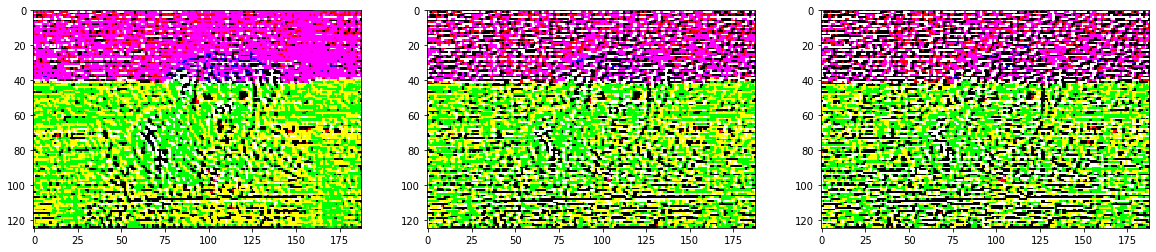

pooling layer block2_pool


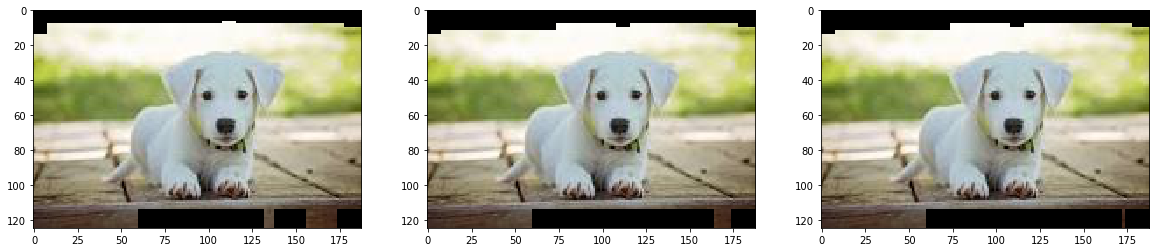

pooling layer block3_pool


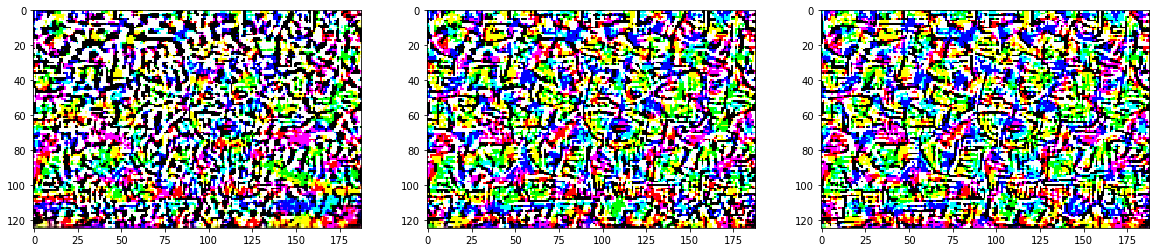

pooling layer block4_pool


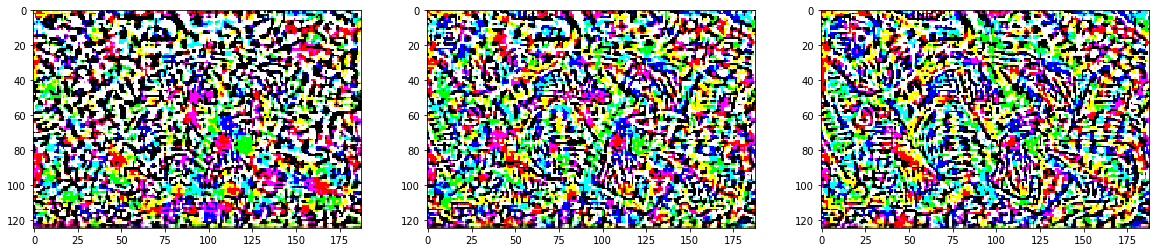

pooling layer block5_pool


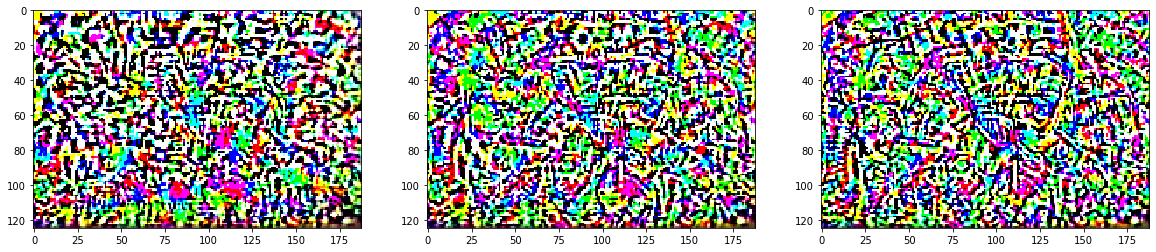

In [20]:
for i in range(num_pool_layers):
    layer_name="block{:d}_pool".format(i+1)
    print("pooling layer {:s}".format(layer_name))
    layer_output=layer_dict[layer_name].output
    
    #loss
    loss=K.mean(layer_output)
    
    #gradient
    grads=K.gradients(loss,dream)[0]
    grads/=(K.sqrt(K.mean(K.square(grads)))+1e-5)
    
    #optimizer
    f=K.function([dream],[loss,grads])
    img_value=p_img.copy()
    fig,axes=plt.subplots(1,num_iters_per_layer,figsize=(20,10))
    for it in range(num_iters_per_layer):
        loss_value,grads_value=f([img_value])
        img_value+=grads_value*step
        axes[it].imshow(deprocess(img_value))
    plt.show()

In [21]:
img=plt.imread("cat1.jpg")
img_copy=img.copy()
print("Original shape ",img.shape)
image_shape_width=img.shape[0]
image_shape_height=img.shape[1]
p_img=preprocess(img_copy)
print("After processing ",p_img.shape)
d_img=deprocess(p_img)
print("After deprocessing ",d_img.shape)

Original shape  (430, 480, 3)
After processing  (1, 430, 480, 3)
After deprocessing  (430, 480, 3)


In [22]:
num_pool_layers = 5
num_iters_per_layer = 3
step = 2000

pooling layer block1_pool


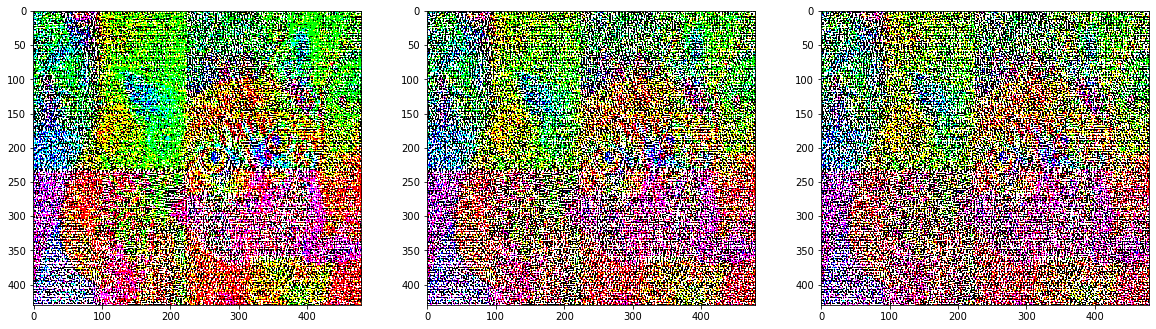

pooling layer block2_pool


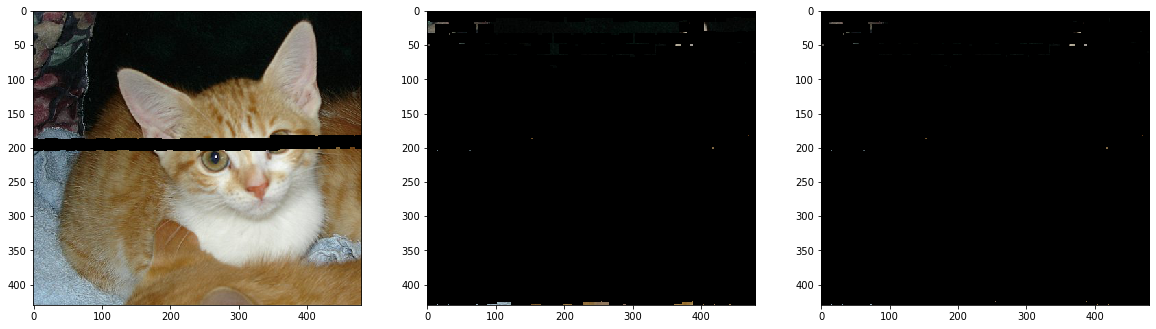

pooling layer block3_pool


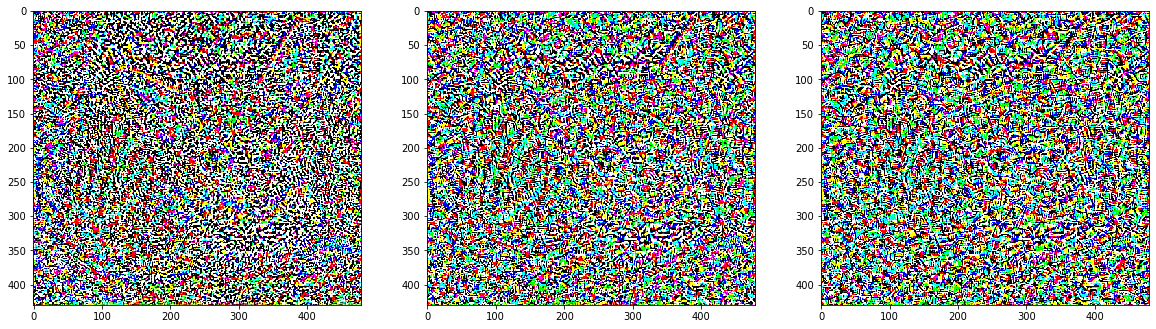

pooling layer block4_pool


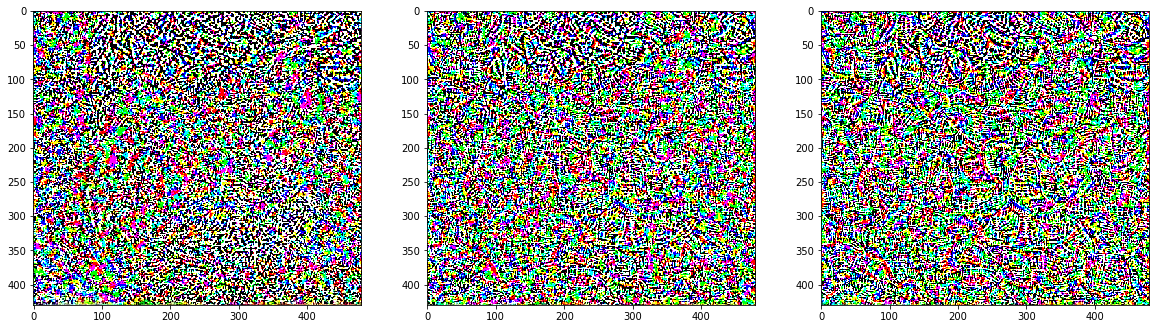

pooling layer block5_pool


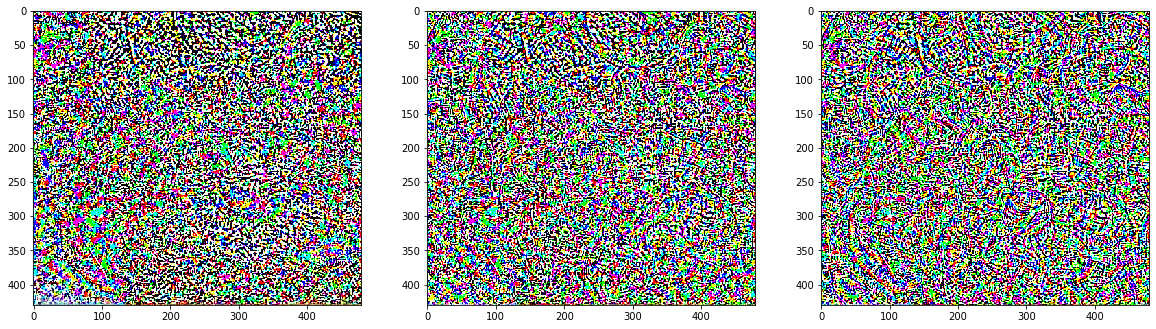

In [23]:
for i in range(num_pool_layers):
    layer_name="block{:d}_pool".format(i+1)
    print("pooling layer {:s}".format(layer_name))
    layer_output=layer_dict[layer_name].output
    
    #loss
    loss=K.mean(layer_output)
    
    #gradient
    grads=K.gradients(loss,dream)[0]
    grads/=(K.sqrt(K.mean(K.square(grads)))+1e-5)
    
    #optimizer
    f=K.function([dream],[loss,grads])
    img_value=p_img.copy()
    fig,axes=plt.subplots(1,num_iters_per_layer,figsize=(20,10))
    for it in range(num_iters_per_layer):
        loss_value,grads_value=f([img_value])
        img_value+=grads_value*step
        axes[it].imshow(deprocess(img_value))
    plt.show()